credit: https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/

In [10]:
# Mathieu Blondel, September 2010
# License: BSD 3 clause
# http://www.mblondel.org/journal/2010/09/19/support-vector-machines-in-python/

# visualizing what translating to another dimension does
# and bringing back to 2D:
# https://www.youtube.com/watch?v=3liCbRZPrZA

# Docs: http://cvxopt.org/userguide/coneprog.html#quadratic-programming
# Docs qp example: http://cvxopt.org/examples/tutorial/qp.html

# Nice tutorial:
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

In [11]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
             
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [12]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

In [13]:
if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

     pcost       dcost       gap    pres   dres
 0: -1.7301e+01 -3.4019e+01  6e+02  2e+01  2e+00
 1: -2.1219e+01 -1.9287e+01  2e+02  9e+00  8e-01
 2: -5.8359e+01 -4.1061e+01  2e+02  7e+00  6e-01
 3: -1.4361e+02 -7.7642e+01  2e+02  6e+00  5e-01
 4: -5.0834e+01 -2.1868e+01  1e+02  2e+00  2e-01
 5: -8.8272e+00 -1.1388e+01  7e+00  5e-02  5e-03
 6: -9.4575e+00 -9.5602e+00  2e-01  1e-03  9e-05
 7: -9.5338e+00 -9.5348e+00  2e-03  1e-05  9e-07
 8: -9.5346e+00 -9.5346e+00  2e-05  1e-07  9e-09
 9: -9.5346e+00 -9.5346e+00  2e-07  1e-09  9e-11
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


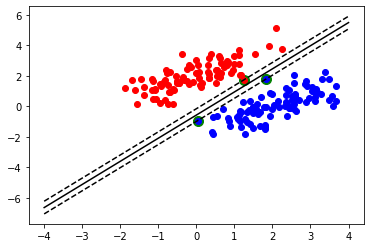

In [14]:
    test_linear()

     pcost       dcost       gap    pres   dres
 0: -4.2524e+01 -1.0168e+02  8e+02  3e+01  2e+00
 1: -6.4374e+01 -7.4768e+01  5e+02  1e+01  1e+00
 2: -1.4645e+01 -4.5906e+00  1e+02  3e+00  3e-01
 3: -2.1849e-01 -5.6444e-01  4e+00  8e-02  7e-03
 4: -4.1278e-02 -4.7594e-01  2e+00  3e-02  3e-03
 5: -6.4165e-02 -3.3032e-01  7e-01  9e-03  8e-04
 6: -1.1225e-01 -2.0665e-01  2e-01  2e-03  2e-04
 7: -1.3702e-01 -1.8584e-01  1e-01  1e-03  1e-04
 8: -1.4450e-01 -1.7779e-01  4e-02  6e-05  6e-06
 9: -1.6309e-01 -1.7228e-01  1e-02  1e-05  1e-06
10: -1.6901e-01 -1.7121e-01  2e-03  1e-06  1e-07
11: -1.7086e-01 -1.7093e-01  7e-05  3e-08  3e-09
12: -1.7092e-01 -1.7092e-01  7e-07  4e-10  3e-11
13: -1.7092e-01 -1.7092e-01  7e-09  4e-12  3e-13
Optimal solution found.
9 support vectors out of 180 points
18 out of 20 predictions correct


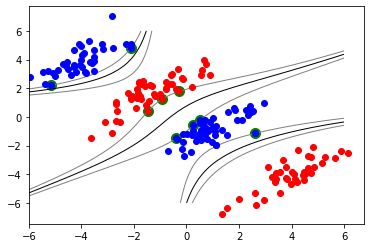

In [15]:
    test_non_linear()

     pcost       dcost       gap    pres   dres
 0:  1.4414e+05 -9.9097e+07  3e+08  6e-01  6e-12
 1:  4.1396e+05 -2.0585e+07  3e+07  5e-02  9e-12
 2:  3.3981e+05 -3.1416e+06  4e+06  6e-03  4e-12
 3:  6.4867e+04 -6.2691e+05  7e+05  6e-04  2e-12
 4: -2.8550e+03 -7.1354e+04  7e+04  1e-05  3e-12
 5: -5.6076e+03 -4.3001e+04  4e+04  7e-06  2e-12
 6: -4.5545e+03 -3.4826e+04  3e+04  4e-06  2e-12
 7: -5.0269e+03 -3.5103e+04  3e+04  4e-06  2e-12
 8: -6.4449e+03 -2.6034e+04  2e+04  2e-06  2e-12
 9: -6.8629e+03 -1.1986e+04  5e+03  3e-07  3e-12
10: -7.4322e+03 -1.1512e+04  4e+03  1e-07  2e-12
11: -8.2875e+03 -1.0196e+04  2e+03  5e-08  3e-12
12: -8.1197e+03 -1.0009e+04  2e+03  4e-08  3e-12
13: -8.2664e+03 -9.7283e+03  1e+03  2e-08  3e-12
14: -8.6499e+03 -9.0152e+03  4e+02  4e-09  4e-12
15: -8.6878e+03 -8.9635e+03  3e+02  2e-09  3e-12
16: -8.7806e+03 -8.8250e+03  4e+01  3e-10  3e-12
17: -8.7945e+03 -8.8046e+03  1e+01  8e-12  3e-12
18: -8.7993e+03 -8.7994e+03  1e-01  3e-13  4e-12
19: -8.7994e+03 -8.79

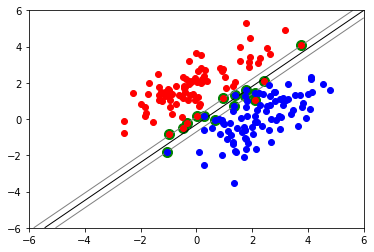

In [16]:
    test_soft()

In [ ]:
# The followings are tests

In [18]:
n_samples = 3
tmp1 = np.diag(np.ones(n_samples) * -1)
tmp2 = np.identity(n_samples)
print(tmp1)
print(tmp2)
G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
print(G)

[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[-1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00 -1.00e+00]
[ 1.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00  0.00e+00]
[ 0.00e+00  0.00e+00  1.00e+00]



In [20]:
C = 5
tmp1 = np.zeros(n_samples)
tmp2 = np.ones(n_samples) * C
print(tmp1)
print(tmp2)
h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
print(h)

[0. 0. 0.]
[5. 5. 5.]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 5.00e+00]
[ 5.00e+00]
[ 5.00e+00]



In [22]:
a=[1,2,3]
a_T=[[1],[2],[3]]
print(np.outer(a,a_T))

[[1 2 3]
 [2 4 6]
 [3 6 9]]
